Exercise 4
=========

This exercise is focused on the influence of boundary conditions on the natural frequencies and modes, as well as on the estimation of transfer functions from time domain data.

You can re-use many things of previous ecercises ...

In [123]:
from scipy.io import mmread
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import inv

from scipy.signal import resample

import scipy.sparse

import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
matplot.rcParams.update({'figure.max_open_warning': 0})

# Uncomment the following line and edit the path to ffmpeg if you want to write the video files!
#plt.rcParams['animation.ffmpeg_path'] ='N:\\Applications\\ffmpeg\\bin\\ffmpeg.exe'

from mpl_toolkits.mplot3d import Axes3D

import sys
# np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=20)

from numpy.fft import rfft, rfftfreq

from utility_functions import Newmark, nullspace

In [2]:
M = csc_matrix(mmread('Ms.mtx')) # mass matrix
K = csc_matrix(mmread('Ks.mtx')) # stiffness matrix
C = csc_matrix(K.shape) # a zeros damping matrix
X = mmread('X.mtx') # coodinate matrix with columns corresponding to x,y,z position of the nodes

N = X.shape[0] # number of nodes

nprec = 6 # precision for finding uniqe values

# get grid vectors (the unique vectors of the x,y,z coodinate-grid)
x = np.unique(np.round(X[:,0],decimals=nprec))
y = np.unique(np.round(X[:,1],decimals=nprec))
z = np.unique(np.round(X[:,2],decimals=nprec))

# grid matrices
Xg = np.reshape(X[:,0],[len(y),len(x),len(z)])
Yg = np.reshape(X[:,1],[len(y),len(x),len(z)])
Zg = np.reshape(X[:,2],[len(y),len(x),len(z)])

tol = 1e-12

# constrain all edges
Nn = np.argwhere(np.abs(X[:,1]-X[:,1].max())<tol).ravel() # Node indices of N-Edge nodes
No = np.argwhere(np.abs(X[:,0]-X[:,0].max())<tol).ravel() # Node indices of O-Edge nodes
Ns = np.argwhere(np.abs(X[:,1]-X[:,1].min())<tol).ravel() # Node indices of S-Edge nodes
Nw = np.argwhere(np.abs(X[:,0]-X[:,0].min())<tol).ravel() # Node indices of W-Edge nodes

Nnosw = np.unique(np.concatenate((Nn,No,Ns,Nw))) #concatenate all and only take unique (remove the double ones)

# special points and the associated nodes
P1 = [0.2,0.12,0.003925]
N1 = np.argmin(np.sum((X-P1)**2,axis=1))
P2 = [0.0,-0.1,0.003925]
N2 = np.argmin(np.sum((X-P2)**2,axis=1))

# all node on the top of the plate
Nt = np.argwhere(np.abs(X[:,2]-X[:,2].max())<tol).ravel()

# indices of x, y, and z DoFs in the global system
# can be used to get DoF-index in global system, e.g. for y of node n by Iy[n]
Ix = np.arange(N)*3 # index of x-dofs
Iy = np.arange(N)*3+1
Iz = np.arange(N)*3+2

# select which indices in the global system must be constrained
If = np.array([Ix[Nnosw],Iy[Nnosw],Iz[Nnosw]]).ravel() # dof indices of fix constraint
Ic = np.array([(i in If) for i in np.arange(3*N)]) # boolean array of constraind dofs

Influence of Boundary Conditions
------------------------------------------------
### Task 1: Soft Springs
Support the plate by flexible springs attached to the corners, and compare the resulting natural frequencies of the first ~10 modes with the ones of the theoretical "free" palte.
* Assume 4 springs at the corners in z-direction, consisting of rubber ($E$=0.1GPa) strings (diameter 2mm) and a length of 1m. How much will the springs elongate under gravity loading?
* How much do the natural frequencies change realteive to the "free" plate? Do the modes change?
* How should you attach the plate (using strings of the given dimension) to have the least impact on natural frequencies and mode shapes?

> Hint: connecting a spring to ground corresponds to adding the spring constant to the diagonal element of the stiffness matrix.

In [3]:
#find corners
# special points and the associated nodes
P1 = [x.max(),y.max(),z.max()]
C1 = np.argmin(np.sum((X-P1)**2,axis=1))

P2 = [x.min(),y.max(),z.max()]
C2 = np.argmin(np.sum((X-P2)**2,axis=1))

P3 = [x.min(),y.min(),z.max()]
C3 = np.argmin(np.sum((X-P3)**2,axis=1))

P4 = [x.max(),y.min(),z.max()]
C4 = np.argmin(np.sum((X-P4)**2,axis=1))

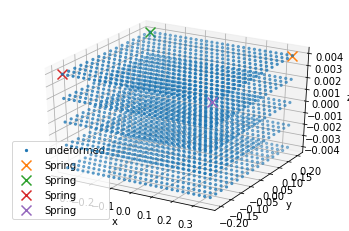

In [4]:
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})

# Plot it in 3D
ax.scatter(X[:,0],X[:,1],X[:,2],s=5,label='undeformed') # undeformed

ax.scatter(X[C1,0],X[C1,1],X[C1,2],s=100,marker='x',label='Spring') # corner
ax.scatter(X[C2,0],X[C2,1],X[C2,2],s=100,marker='x',label='Spring') # corner
ax.scatter(X[C3,0],X[C3,1],X[C3,2],s=100,marker='x',label='Spring') # corner
ax.scatter(X[C4,0],X[C4,1],X[C4,2],s=100,marker='x',label='Spring') # corner


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc = 3)

A bar of length $l_0$ and cross-sectional area $A$ is subjected to a tensile or compressive load (force) along the $z$-axis and causes stress in the bar in the $z$-direction:

\begin{equation}
    \sigma_x  = \frac{F_z}{A}
\end{equation}

This results in an elongation $\varepsilon_z$ of the bar in $z$ direction:

\begin{equation}
    \varepsilon_z  = \frac{\Delta l }{l_0}
\end{equation}

The elongation of the bar depends on the force acting, in this case the stress in the bar. The proportionality constant $E$ represents the modulus of elasticity of the material of which the bar consists.

\begin{equation}
    \sigma_z = E \cdot \varepsilon_z
\end{equation}

By inserting the first two formulas and rearranging them, the following representation is obtained:

\begin{equation}
    F_z  = E \cdot A \cdot \frac{\Delta l}{l_0} \\
    F_z  = k_{spring} \cdot \Delta l
\end{equation}

Hooke's law can thus be applied where the acting force depends almost linearly on the deflection or extension, and is a generalization of Hooke's law for springs.

We can finally write the spring stiffness as

\begin{equation}
    k_{spring} = \frac{E \cdot A}{l_0}
\end{equation}


In [5]:
# Calculate the spring stiffness
E = 0.1*1e9 #N/m^2
d = 2.0*1e-3 #m
l0 = 1.0 #m
A = d**2*np.pi/4 #m^2
k_spring = E*A/l0 #N/m

# calculate static deformation
g = 9.81 #m/s^2
m_ges = np.sum(M[Iz,Iz]) #kg
F_ges = m_ges*g #N
k_spring_ges = 4*k_spring
dL = F_ges/k_spring_ges
print('The springs elongate under gravity: ' + str(dL) + ' m')
print('The springs elongate under gravity: ' + str(dL*1e3) + ' mm')

The springs elongate under gravity: 0.005999223773265883 m
The springs elongate under gravity: 5.999223773265883 mm


#### First we calculate the frequencies without the springs attached

In [6]:
# only compute a subset of modes of the reduced model
k = 10
W,V = eigsh(K,k,M,sigma=0,which='LM',maxiter = 1000)

#### Now calculate everything with springs attached

In [7]:
# Build a new K-Matrix
Ks = K[:,:]

# Add springs to the corners
Ks[Iz[C1],Iz[C1]] += k_spring
Ks[Iz[C2],Iz[C2]] += k_spring
Ks[Iz[C3],Iz[C3]] += k_spring
Ks[Iz[C4],Iz[C4]] += k_spring

In [8]:
Ws,Vs = eigsh(Ks,k,M,sigma=0,which='LM',maxiter = 1000)

In [9]:
def plotmodes(V_var,W_var) :
    for i,v in enumerate(V_var.T) : # iterate over eigenvectors
        c = np.reshape(v[Iz[Nt]],[len(y),len(x)])
        lim = np.max(np.abs(c))
        fig,ax = plt.subplots(nrows=1, ncols=1,figsize=[3.5,2])
        ax.contourf(x,y,c,cmap=plt.get_cmap('RdBu'),vmin=-lim,vmax=lim)
        ax.set_aspect('equal')
        ax.set_title('Mode %i @ %f Hz'%(i+1,np.sqrt(abs(W_var[i]))/2/np.pi))
        ax.set_xticks([])
        ax.set_yticks([])
        fig.tight_layout()

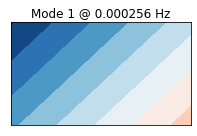

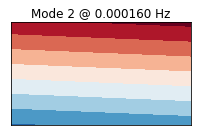

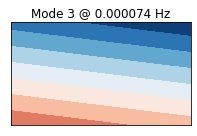

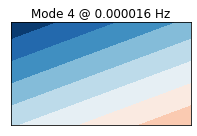

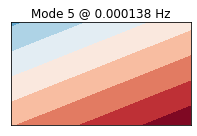

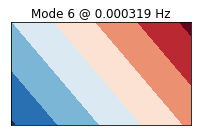

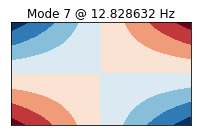

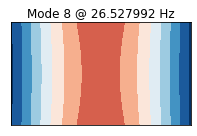

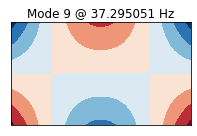

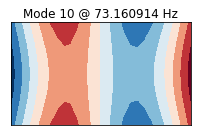

In [10]:
# Plot Modes
plotmodes(V,W)

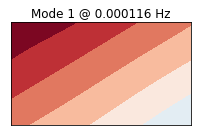

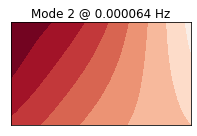

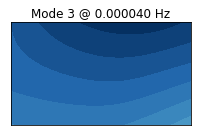

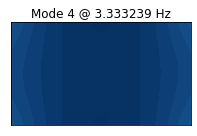

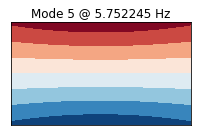

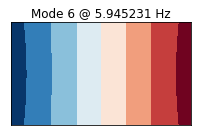

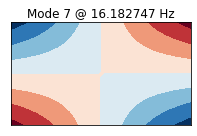

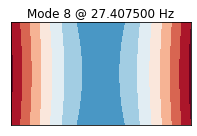

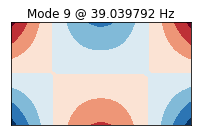

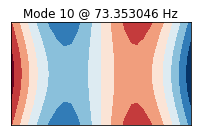

In [11]:
# Plot modes
plotmodes(Vs,Ws)

### Clamped Plate
The plate is clamped at all edges. 
To clamp a real plate at the outer dimensions of our model plate, we fabricate it larger by a distance $d_s = 1.5 t_s$, where $t_s$ is the thickness of the plate, and clamp it between two stiff flanges.

To estimate the stiffness of this clamped support, we use a very simplified model: Assume the flanges are rigid, but we use a layer of rubber with thickness $h_s$=1mm between them. 
The vertical bedding stiffness (stress per displacement) of this support can easily be computed: $k_z = 2 E_s/h_s$
To compute the equivalent springs stiffness to apply to the nodes, multiply the bedding stiffness by appropriate "nodal areas".
To model the response of the support with respect to rotations of the plate, apply a bedding stiffness in normal direction of the vertical plate edges (i.e. springs acting in x- or y-directions).
The bedding stiffness in this case can be estimated by requiring that a small rotation delivers the same bending moment for both cases: one obtains $k_x=k_y=8(t_s/d_s)^3k_z$.

Compare the theoretical clamped model (as in the previous examples), with the more realistic "flexible" clamping described above.
* what are the difference in natural frequencies?
* plot the mode shapes? Do they differ?

In [12]:
# Calculate distance
ts = z.max() - z.min() #in m
b = y.max() - y.min() #in m
h = x.max() - x.min() #in m

dX = h/(len(x)-1) #Grid spacing
dY = b/(len(y)-1) #Grid spacing
dZ = ts/(len(z)-1) #Grid spacing

ds = 1.5*ts #plate larger by ds in m

In [13]:
# rubber flanges
hs = 1*1e-3 #m

# Stiffness
kz = 2*E/hs #N/m
kxy = 8*(ts/ds)**3*kz #N/m

In [14]:
# calculate equivalent springs stiffness
Ao = b*h #in m^2
At = (b+2*ds)*(h+2*ds) #in m^2
Ad = At - Ao #in m^2

dAx = dY*dZ  #nodal area
dAy = dX*dZ  #nodal area
dAz = dY*dX  #nodal area

kxy = kxy*dAz/Ad
kz = kz*dAz/Ad

In [15]:
N1 = np.argwhere((np.abs(X[:,1]-X[:,1].max()) + np.abs(X[:,2]-X[:,2].max())) < tol).ravel()
N2 = np.argwhere((np.abs(X[:,1]-X[:,1].max()) + np.abs(X[:,2]-X[:,2].min())) < tol).ravel()

N3 = np.argwhere((np.abs(X[:,0]-X[:,0].max()) + np.abs(X[:,2]-X[:,2].max())) < tol).ravel()
N4 = np.argwhere((np.abs(X[:,0]-X[:,0].max()) + np.abs(X[:,2]-X[:,2].min())) < tol).ravel()

N5 = np.argwhere((np.abs(X[:,1]-X[:,1].min()) + np.abs(X[:,2]-X[:,2].max())) < tol).ravel()
N6 = np.argwhere((np.abs(X[:,1]-X[:,1].min()) + np.abs(X[:,2]-X[:,2].min())) < tol).ravel()

N7 = np.argwhere((np.abs(X[:,0]-X[:,0].min()) + np.abs(X[:,2]-X[:,2].max())) < tol).ravel()
N8 = np.argwhere((np.abs(X[:,0]-X[:,0].min()) + np.abs(X[:,2]-X[:,2].min())) < tol).ravel()

Nb = np.unique(np.concatenate((N1,N2,N3,N4,N5,N6,N7,N8)))

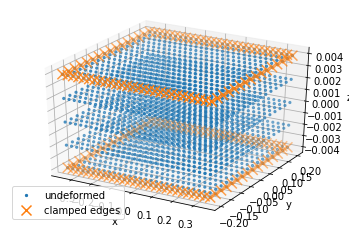

In [16]:
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})

# Plot it in 3D
ax.scatter(X[:,0],X[:,1],X[:,2],s=5,label='undeformed') # undeformed

ax.scatter(X[Nb,0],X[Nb,1],X[Nb,2],s=100,marker='x',label='clamped edges') # corner

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc = 3)

In [17]:
# Build a new K-Matrix
Kc2 = K[:,:]

for i,node in enumerate(Nb) :
    # Add springs to the corners
    Kc2[node*3,node*3] += kxy
    Kc2[node*3+1,node*3+1] += kxy
    Kc2[node*3+2,node*3+2] += kz

In [18]:
# compute the reduced system
Kc = csc_matrix(K[np.ix_(~Ic,~Ic)])
Mc = csc_matrix(M[np.ix_(~Ic,~Ic)])
Cc = csc_matrix(C[np.ix_(~Ic,~Ic)])

In [19]:
# only compute a subset of modes of the reduced model
k = 10
Wc2,Vc2 = eigsh(Kc2,k,M,sigma=0,which='LM',maxiter = 1000)

In [20]:
# only compute a subset of modes of the reduced model
k = 10
Wc,Vc = eigsh(Kc,k,Mc,sigma=0,which='LM',maxiter = 1000)

Vc_full = np.zeros_like(Vc2)
Vc_full[~Ic] = Vc

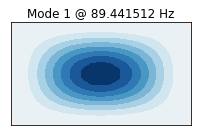

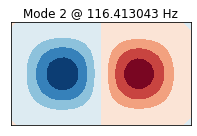

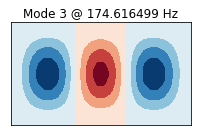

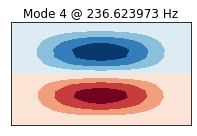

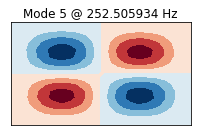

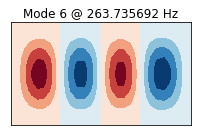

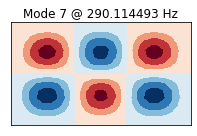

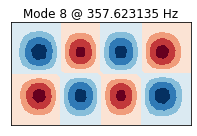

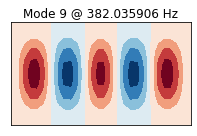

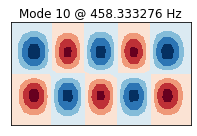

In [21]:
# Plot modes
plotmodes(Vc2,Wc2)

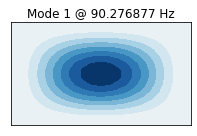

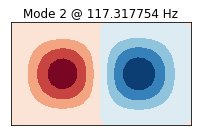

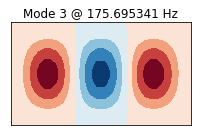

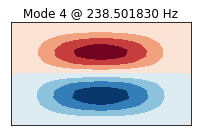

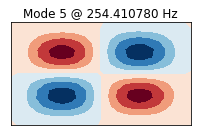

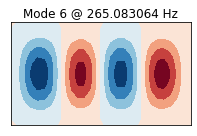

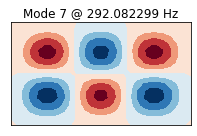

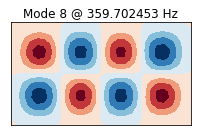

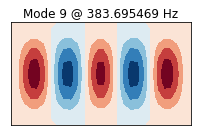

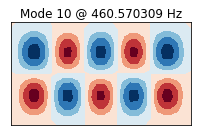

In [22]:
# Plot modes
plotmodes(Vc_full,Wc)

Shaker and Interactions
----------------------------------

### Shaker Model

Assume a shaker model with table (mass $m_t$=2kg) and body (mass $m_b$=10kg) connedcted by spring and dashpot ($k_t$=20kN/m and $c_t$=20Ns/m, respectively). 
The body is flexibly connected to the ground with support stiffness $k_b$=160MN/m and damping constant $c_b$=400Ns/m.
The coil has an ohmic resistance $R$=0.5Ohm and inductance $L$=100$\mu$H.
Electromagnetic force and induced voltage (electromotive force) are related to the current and relative velocity, respecively, by $B_l$=50Tm.

* Plot the transfer function of the coil current with respect to voltage excitation
* Plot the transfer functions of the displacment dofs with respect to voltage excitation

### Answer:
We model the shaker by an ODE system of the form 
$$
\boldsymbol{M}\ddot{\boldsymbol{x}}+\boldsymbol{c}\dot{\boldsymbol{x}}+\boldsymbol{K}\boldsymbol{x} = \boldsymbol{f(t)}
$$
Note: The model is depicted in the lecture slides on p.22(116) of lecture 4.
The system's equations can be derived via balance laws for the mechanical (Newton's law) and electrical (Kirchoff's voltage law (KVL)) systems. For the coupling equations we have: 
First, the magnetic force 
$$
F_m=B_l i(t),
$$
which couples the electrical to the mechanical system. 
Second, the change in relative displacement from the mechanical system induces a voltage 
$$
V_e(t) = B_l (\dot{x_t}-\dot{x_b})
$$
on the electrical system. We choose $ \boldsymbol{x}=[x_t\quad x_b\quad V_e]^T $ and recast the equations into matrix form

$$
\begin{bmatrix}
m_t & 0 & 0\\
0 & m_b & 0 \\
0 & 0 & 0 \\
\end{bmatrix}
\ddot{\boldsymbol{x}}
+
\begin{bmatrix}
c_t & -c_t & 0\\
-c_t & c_t+c_b & 0 \\
B_l & -B_l & L \\
\end{bmatrix}
\dot{\boldsymbol{x}}
+
\begin{bmatrix}
k_t & -k_t & -B_l\\
-k_t & k_t+k_b & B_l \\
0 & 0 & R \\
\end{bmatrix}
\boldsymbol{x}
=
\begin{bmatrix}
0\\
0\\
V(t)\\
\end{bmatrix}.
$$

In [23]:
# Mechanical parameters
m_t = 2 # [kg] mass table
m_b = 10 # [kg] mass body
k_t = 20E3 # [N/m] spring top
c_t = 20E3 # [Ns/m] dashpot top
k_b = 160E6 # [N/m] spring support
c_b = 400 # [Ns/m] dashpot support

# Electrical parameters
R = 0.5 # [Ohm] coil resistance
L = 100E-6 # [T] coil inductance
B_l = 50 # [Tm] magnetic flux density * length of coil

# Assign system matrices M, C and K
M_shaker = np.diag([m_t, m_b, 0])
C_shaker = np.array([
        [c_t, -c_t, 0],
        [-c_t, c_t + c_b, 0],
        [B_l, -B_l, L]
])

K_shaker = np.array([
        [k_t, -k_t, -B_l],
        [-k_t, k_t + k_b, B_l],
        [0, 0, R]
])

### How to obtain TF 
-to be done-

In [24]:
f = np.linspace(0, 10E3, 100) # [Hz] frequency array 
w = 2*np.pi*f # [rad/s] angular freq. array


### Interactions between Shaker and Plate

Couple the plate and shaker model using a flexible steel stinger (rod) with a length $l_r$=100mm and diameter $d_r$=4mm. The rod should connect to the plate at $P_1$=(0.2,0.12,0.003925)m, and excite the plate in z-direction.

* Compute the coupled natural frequencies of the system.
* Plot the mode shapes.

Tipps:
* Combine the plate system matrix and the shaker model in a single matrix
* The rod/stinger can be included in the shaler model by adding a displacement dof for the end (the start corresponds to the table displacement). The mass off the stinger can be lumped (distributed) to the two dofs.
* You can combine spare matrices by using `scipy.sparse.hstack()` and `scipy.sparse.vstack()`
* Use the nullspace to connect the dof of the of the rod to the dof on the plate

In [25]:
# Attach at
P1 = [0.2,0.12,0.003925]

# input parameters
l_rod = 0.1 # [m] length rod
d_rod = 4E-3 # [m] diameter rod
E = 210E9 # [Pa] Young's modulus steel
density = 7850 # [kg/m^3] Density of generic steel

# Steel stinger
A_rod = d_rod**2*np.pi/4 # Cross sectional area
k_rod = E*A_rod/l_rod # Stiffness constant
m_rod = density*A_rod*l_rod # Mass


### How to couple the two systems?
EXPLANATION ... -to be done-

In [26]:
# Add steel stinger/rod to shaker system (sr = shaker+rod)

M_shaker_added_mass = M_shaker
M_shaker_added_mass[0,0] = M_shaker[0,0] + m_rod/2 # Add m_rod/2 from rod to top of shaker

M_sr = np.block([ 
    [m_rod/2, np.zeros((1,3))],
    [np.zeros((3,1)), M_shaker]
])

C_sr = np.block([
    [np.zeros((1,4))],
    [np.zeros((3,1)), C_shaker]
])

K_sr = np.array([ # NOTE: Think about a more elegant way to do this since there exists a block matrix pattern!
    [k_rod, -k_rod, 0, 0],
    [-k_rod, k_rod + k_t, -k_t, -B_l],
    [0,-k_t, k_t + k_b, B_l],
    [0, 0, 0, R]
])

# Combine system matrices
M_plateshaker_uncoupled = scipy.sparse.block_diag((M, M_sr))
C_plateshaker_uncoupled = scipy.sparse.block_diag((C, C_sr))
K_plateshaker_uncoupled = scipy.sparse.block_diag((Kc2, K_sr))

# Couple rod and plate at P1

N1 = np.argmin(np.sum((X-P1)**2,axis=1)) # Select node
DOF_rod = M_plateshaker_uncoupled.shape[0] - 4 # Select DOF of rod
B_rod_plate = np.zeros((1, M_plateshaker_uncoupled.shape[0])).T # Build constraint matrix
B_rod_plate[Iz[N1]] = 1 # DOF Iz[N1] = DOF rod constraint
B_rod_plate[DOF_rod] = -1
B_rod_plate = B_rod_plate.T

Q_rod_plate = csc_matrix(nullspace(B_rod_plate)) # Get nullspace for constraint matrix B_rod_plate
M_plateshaker = Q_rod_plate.T @ M_plateshaker_uncoupled @ Q_rod_plate # Constrain by similarity transformation
C_plateshaker = Q_rod_plate.T @ C_plateshaker_uncoupled @ Q_rod_plate
K_plateshaker = Q_rod_plate.T @ K_plateshaker_uncoupled @ Q_rod_plate




Data Display and FRF Estimation
-----------------------------------------------

### Task 2: Chrip Signal
Define a Chirp signal to cover the first 10 modes of the (realistically) clamped plate. Use a signal length of 0.5s.
* Plot time signal and frequency spectrum of the signal.

In [27]:
import matplotlib.pyplot as plt
import matplotlib.axes as ax

import time

In [28]:
## only compute a subset of modes of the reduced model
k = 10
W,V = eigsh(Kc2,k,M,sigma=0,which='LM',maxiter = 1000)
print(np.sqrt(W)/2/np.pi)

[ 89.4415123  116.41304335 174.61649913 236.62397283 252.50593359
 263.73569182 290.11449288 357.62313468 382.03590601 458.33327594]


In [29]:
## Chirp signal t cover the first 10 modes with signal lenght of 0,5s
sig_lenght = 0.5 #signal lenght
f_min = round((np.sqrt(W[0])/2/np.pi)-50) #first mode in Hz -50Hz to cover all
f_max = round((np.sqrt(W[9])/2/np.pi)+50) #tenth mode in Hz +50Hz to cover all
steps = 2**13
dt = sig_lenght/steps
f_sample = 1/dt
t = np.linspace(0, sig_lenght, steps)
y_t = np.sin(2*np.pi*t*(f_min + (f_max - f_min) * (t/sig_lenght))) #Chrip in time domain

f = rfftfreq(t.size, dt)
y_f = rfft(y_t)
y_f_abs = np.abs(y_f)

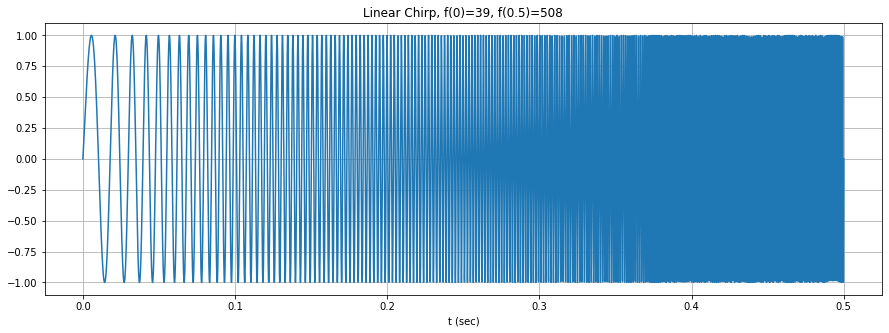

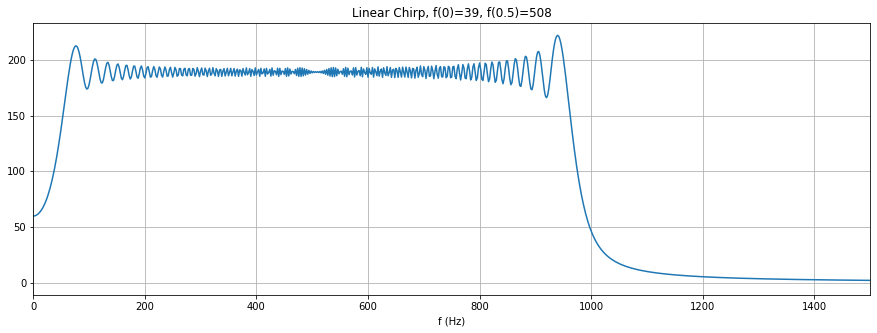

In [30]:
## Plot of time signal 
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(t, y_t)
plt.title("Linear Chirp, f(0)="+str(int(round((np.sqrt(W[0])/2/np.pi)-50)))+", f("+str(sig_lenght)+")="+str(int(round((np.sqrt(W[9])/2/np.pi)+50))))
plt.xlabel('t (sec)')
plt.grid()
plt.show()

## Plot of the frequency spectrum
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(f, y_f_abs)
plt.title("Linear Chirp, f(0)="+str(int(round((np.sqrt(W[0])/2/np.pi)-50)))+", f("+str(sig_lenght)+")="+str(int(round((np.sqrt(W[9])/2/np.pi)+50))))
plt.xlabel('f (Hz)')
plt.xlim(0, 1500)
plt.grid()
plt.show()

* What start and end frequency did you choose?

In [31]:
print(f_min)
print(f_max)

39.0
508.0


### Shaker Experiment
Use the coupled shaker and plate model, and excite the shaker with the Chirp signals as voltage input.
Compute the transient response. 
Assume Rayleigh damping with $\alpha=2.15$ and $\beta=3e-5$ for the plate.

In [32]:
#assemble Damping-Matrix for the reduced sys and given aplha and beta for Rayleigh damping
alpha = 2.15
beta = 0.00003
C = alpha * M + beta * Kc2
C_plateshaker_uncoupled = scipy.sparse.block_diag((C, C_sr))
C_plateshaker = Q_rod_plate.T @ C_plateshaker_uncoupled @ Q_rod_plate

In [33]:
# assemble forcing vector
force = np.array(np.zeros((3*N+4, y_t.shape[0]))) # Initialize load vector array; Note that the columns contain the force values from 0 to T!
force[-1,:] = y_t # chirp signal as voltage input
f_plateshaker = Q_rod_plate.T @ force

In [34]:
start_time = time.time()

# Time integration with Newmark-Method
u0 = np.zeros(3*N+3) # Initial displacement set to 0.
u_Q, v_Q, a_Q = Newmark(M_plateshaker, C_plateshaker, K_plateshaker, f_plateshaker, t, u0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 79.96027112007141 seconds ---


In [35]:
# Transformation into the original system
u = Q_rod_plate @ u_Q
v = Q_rod_plate @ v_Q
a = Q_rod_plate @ a_Q

# gather displacement of tabel x_t, displacement of membran x_b and coil current
x_t = u[-3,:]
x_t_dot = v[-3,:]
x_t_ddot = a[-3,:]
x_b = u[-2,:]
x_b_dot = v[-2,:]
x_b_ddot = a[-2,:]
current = u[-1,:]

* Plot the time signal of the coil current

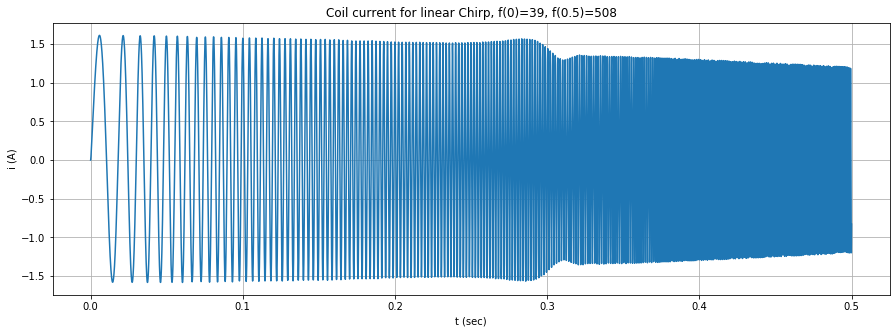

In [36]:
# plot time signal of the coil current
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(t, current)
plt.title("Coil current for linear Chirp, f(0)="+str(int(round((np.sqrt(W[0])/2/np.pi)-50)))+", f("+str(sig_lenght)+")="+str(int(round((np.sqrt(W[9])/2/np.pi)+50))))
plt.xlabel('t (sec)')
plt.ylabel('i (A)')
plt.grid()
plt.show()

* Plot the time signal of the center point displacement (in z direction) of the plate

In [37]:
#find node number in the center
PC = [0.,0.,0.]
NC = np.argmin(np.sum((X-PC)**2,axis=1))
PC_disp_z = u[Iz[NC],:]

# PC_disp_z_f = rfft(PC_disp_z)
# PC_disp_z_f_abs = np.abs(PC_disp_z_f)

In [38]:
PC_disp_z.shape

(8192,)

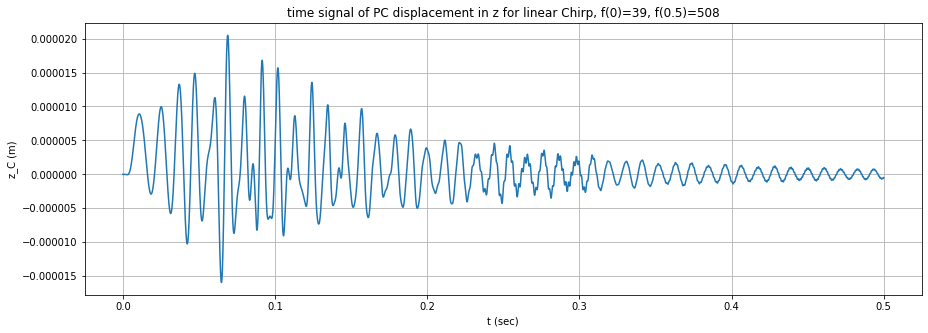

In [39]:
# plot time signal of PC displacement in z for linear Chirp
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(t, PC_disp_z)
plt.title("time signal of PC displacement in z for linear Chirp, f(0)="+str(int(round((np.sqrt(W[0])/2/np.pi)-50)))+", f("+str(sig_lenght)+")="+str(int(round((np.sqrt(W[9])/2/np.pi)+50))))
plt.xlabel('t (sec)')
plt.ylabel('z_C (m)')
plt.grid()
plt.show()

# # plot frequence spec of PC displacement in z for linear Chirp
# fig, ax = plt.subplots(figsize=(15,5))
# plt.plot(f, PC_disp_z_f_abs)
# plt.title("frequence spec of PC displacement in z for linear Chirp, f(0)="+str(int(round((np.sqrt(W[0])/2/np.pi)-50)))+", f("+str(sig_lenght)+")="+str(int(round((np.sqrt(W[9])/2/np.pi)+50))))
# plt.xlabel('f (sec)')
# plt.grid()
# plt.show()

* Compute the time signal of the force in the stinger exciting the plate, and plot it.

In [40]:
# displacemet of point where shaker is connected
P1_disp_z = u[Iz[N1],:]
F_stinger = k_rod * (P1_disp_z - x_t)

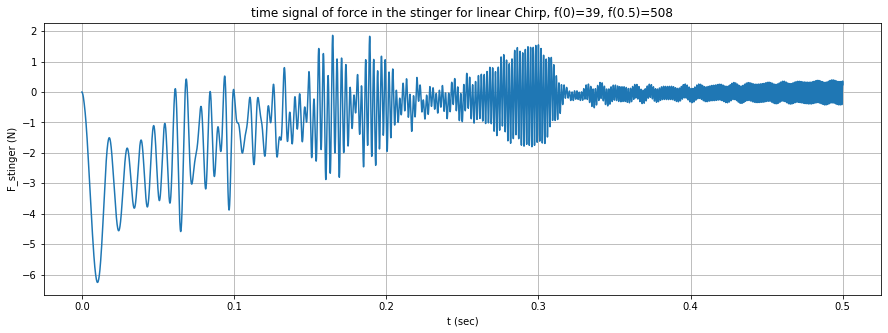

In [41]:
# plot time signal of the force in the stinger exciting the plate
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(t, F_stinger)
plt.title("time signal of force in the stinger for linear Chirp, f(0)="+str(int(round((np.sqrt(W[0])/2/np.pi)-50)))+", f("+str(sig_lenght)+")="+str(int(round((np.sqrt(W[9])/2/np.pi)+50))))
plt.xlabel('t (sec)')
plt.ylabel('F_stinger (N)')
plt.grid()
plt.show()

another method:
From equation of motion
$$
m_t \ddot{x_t} + c_t (\dot{x_t} -\dot{x_b}) + k_t (x_t - x_b) - f_m = F_{stinger}
$$
$$
f_m =  B_l i
$$

In [42]:
# Compute force of stinger from principe of linear momentum
F_stinger_2 = m_t * x_t_ddot + c_t * (x_t_dot - x_b_dot) + k_t * (x_t - x_b) - B_l * current

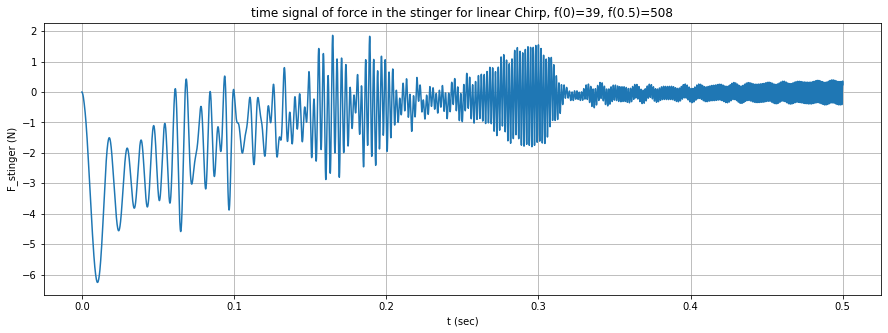

In [43]:
# plot time signal of the force in the stinger exciting the plate
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(t, F_stinger_2)
plt.title("time signal of force in the stinger for linear Chirp, f(0)="+str(int(round((np.sqrt(W[0])/2/np.pi)-50)))+", f("+str(sig_lenght)+")="+str(int(round((np.sqrt(W[9])/2/np.pi)+50))))
plt.xlabel('t (sec)')
plt.ylabel('F_stinger (N)')
plt.grid()
plt.show()

### FRF Estimation

Use the FFT compute the frequency spectrum of the response.
Estimate transfer functions between system parameters by dividing the respective frequency spectra, e.g. output displacement divided by input voltage.
In order to estimate the transfer function of the plate with respect to a vertical force, you need to compute the ratio of two output quantities of the model.

Compute the harmonic response of the system as a reference solution for the transfer functions estimated from time domain data.

Tipp: Only compute the harmonic solution in a suitable frequency range! For easier computation of differences use a common frequency resolution.

In [44]:
from scipy.sparse.linalg import spsolve

def FrequencyDomain(omega, direc = Iz, node = N1):
    #1. Compute the dynamic stiffness matrix K for one omega
    #Z = Kc.toarray() + complex(0,1) * omega * Cc.toarray() - omega**2 * Mc.toarray() #for sparse matrices
    Z = Kc2 + complex(0,1) * omega * C - omega**2 * M     #for np.arrays
    
    #2. Assemble one (or several) forcing vectors
    f_hat = np.zeros(3*N)
    f_hat[direc[node]] = 1.0    #for sys without constrains and force acting on N1 which is the closest node to P1
    
    #3. solve for the displacements
    x_hat = spsolve(Z,f_hat)       #for spare matrices
    #x_hat = np.linalg.solve(Z,fc_hat)   #for np.array's
    
    return(x_hat) #complex, so ampl and phase is in there; for all DoF which are not constrained

#def FrequencyDomainShaker(omega, direc = Iz, node = N1):
    #1. Compute the dynamic stiffness matrix K for one omega
    #Z = Kc.toarray() + complex(0,1) * omega * Cc.toarray() - omega**2 * Mc.toarray() #for sparse matrices
    #Z = Kc2 + complex(0,1) * omega * C - omega**2 * M     #for np.arrays
    
    #2. Assemble one (or several) forcing vectors
    #f_hat = np.zeros(3*N)
    #f_hat[direc[node]] = 1.0    #for sys without constrains and force acting on N1 which is the closest node to P1
    
    #3. solve for the displacements
    #x_hat = spsolve(Z,f_hat)       #for spare matrices
    #x_hat = np.linalg.solve(Z,fc_hat)   #for np.array's
    
    #return(x_hat) #complex, so ampl and phase is in there; for all DoF which are not constrained

In [111]:
f_idx_upper = int(np.where(f == f[f <= f_max][-1])[0])
f_idx_lower = int(np.where(f == f[f >= f_min][0])[0])
new_window = f[f_idx_lower:f_idx_upper]

Nr_steps = len(new_window)

In [112]:
# Use W and V from previous calc
#k = 50
#W,V = eigsh(Kc2,k,M,sigma=0,which='LM',maxiter = 1000) # takes way to long to find samllest values

start_time = time.time()

C = csc_matrix(C)

#frequency range from 2Hz to 300Hz and ~150 frequency points
PC_resp_z = np.zeros([Nr_steps,2]) #+ complex(0,0)
counter = 0
frequency = np.linspace(f_min,f_max,Nr_steps)

for i in frequency:
    resp = FrequencyDomain(2*np.pi*i)

    #Amplitude in dB
    PC_resp_z[counter,0] = 20*np.log10(np.abs(resp[Iz[NC]]))
    #Phase in degree
    PC_resp_z[counter,1] = np.angle(resp[Iz[NC]])*180/np.pi

    counter += 1
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 272.7446093559265 seconds ---


* Estimate the transfer function between input voltage and vertical center point displacement of the plate.
* Plot the estimated FRF and the reference solution from a hamonic analysis to compare them.

In [129]:
estimated_tf = rfft(PC_disp_z)/rfft(y_t)
Ampl = 20*np.log10(np.abs(estimated_tf))
Phase = np.angle(estimated_tf)*180/np.pi

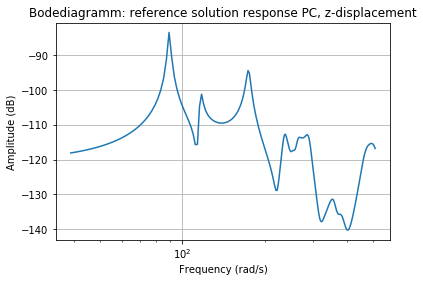

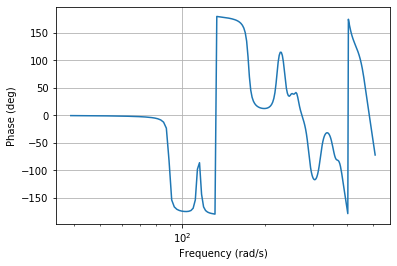

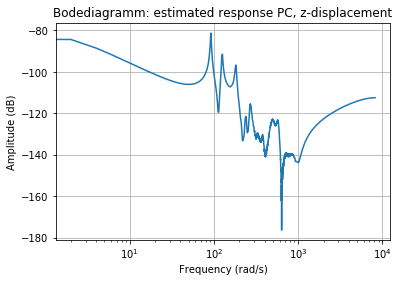

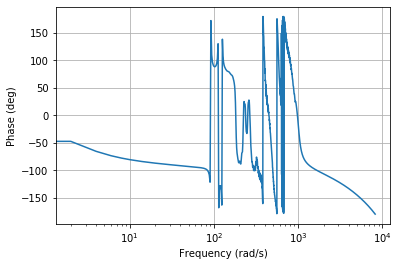

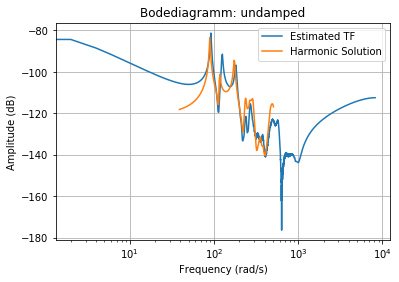

In [130]:
#plot response in z for PC
plt.plot(frequency, PC_resp_z[:,0])
plt.title('Bodediagramm: reference solution response PC, z-displacement')
plt.ylabel('Amplitude (dB)')
plt.xlabel('Frequency (rad/s)')
plt.xscale('log')
#plt.xlim(1, 1000)
plt.grid(True)
plt.show()

plt.plot(frequency, PC_resp_z[:,1])
plt.ylabel('Phase (deg)')
plt.xlabel('Frequency (rad/s)')
plt.xscale('log')
#plt.xlim(1, 1000)
plt.grid(True)
plt.show()

#plot response in z for PC
plt.plot(f, Ampl)
plt.title('Bodediagramm: estimated response PC, z-displacement')
plt.ylabel('Amplitude (dB)')
plt.xlabel('Frequency (rad/s)')
plt.xscale('log')
#plt.xlim(1, 1000)
plt.grid(True)
plt.show()

plt.plot(f, Phase)
plt.ylabel('Phase (deg)')
plt.xlabel('Frequency (rad/s)')
plt.xscale('log')
#plt.xlim(1, 1000)
plt.grid(True)
plt.show()

#compare amplitude
plt.plot(f, Ampl,label='Estimated TF')
plt.plot(frequency, PC_resp_z[:,0],label='Harmonic Solution')
plt.title('Bodediagramm: undamped')
plt.ylabel('Amplitude (dB)')
plt.xlabel('Frequency (rad/s)')
plt.xscale('log')
#plt.xlim(1, 1000)
plt.grid(True)
plt.legend()
plt.show()

#together plot

* Estimate the FRF from plate force to center displacement from the coupled shaker model.


In [131]:
estimated_tf2 = rfft(PC_disp_z)/rfft(F_stinger) #another output
Ampl2 = 20*np.log10(np.abs(estimated_tf2))
Phase2 = np.angle(estimated_tf2)*180/np.pi

* Plot the estimate from the time domain to the harmonic reference solution. Compute the $\Delta$FRF to compare.

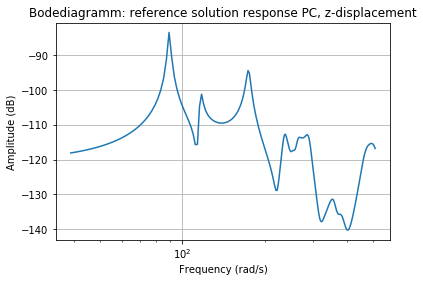

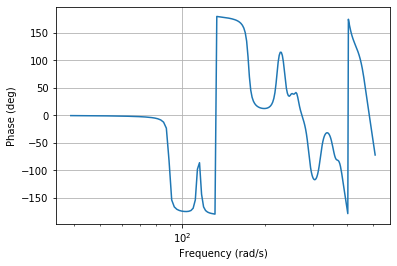

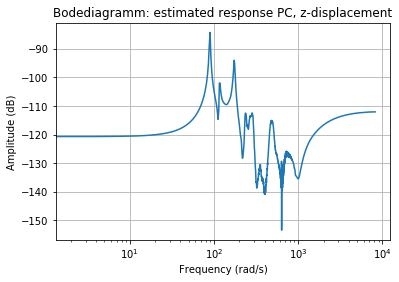

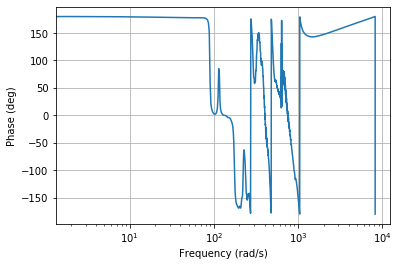

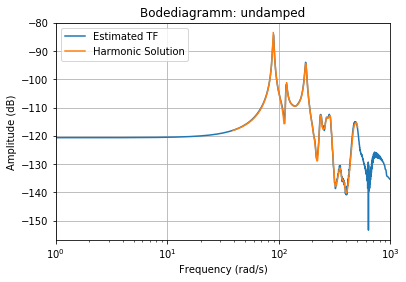

In [132]:
#plot response in z for PC
plt.plot(frequency, PC_resp_z[:,0])
plt.title('Bodediagramm: reference solution response PC, z-displacement')
plt.ylabel('Amplitude (dB)')
plt.xlabel('Frequency (rad/s)')
plt.xscale('log')
#plt.xlim(1, 1000)
plt.grid(True)
plt.show()

plt.plot(frequency, PC_resp_z[:,1])
plt.ylabel('Phase (deg)')
plt.xlabel('Frequency (rad/s)')
plt.xscale('log')
#plt.xlim(1, 1000)
plt.grid(True)
plt.show()

#plot response in z for PC
plt.plot(f, Ampl2)
plt.title('Bodediagramm: estimated response PC, z-displacement')
plt.ylabel('Amplitude (dB)')
plt.xlabel('Frequency (rad/s)')
plt.xscale('log')
#plt.xlim(1, 1000)
plt.grid(True)
plt.show()

plt.plot(f, Phase2)
plt.ylabel('Phase (deg)')
plt.xlabel('Frequency (rad/s)')
plt.xscale('log')
#plt.xlim(1, 1000)
plt.grid(True)
plt.show()

#compare amplitude
plt.plot(f, Ampl2,label='Estimated TF')
plt.plot(frequency, PC_resp_z[:,0],label='Harmonic Solution')
plt.title('Bodediagramm: undamped')
plt.ylabel('Amplitude (dB)')
plt.xlabel('Frequency (rad/s)')
plt.xscale('log')
plt.xlim(1, 1000)
plt.grid(True)
plt.legend()
plt.show()

#together plot

In [134]:
delta_frf = Ampl2[f_idx_lower:f_idx_upper] - PC_resp_z[:,0]

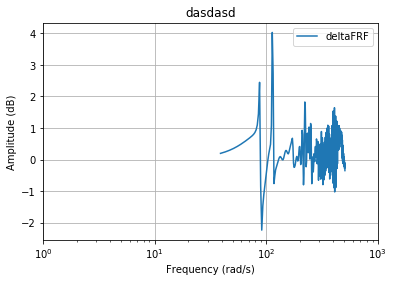

In [138]:
#compare amplitude
plt.plot(frequency, delta_frf,label='deltaFRF')
plt.title('dasdasd')
plt.ylabel('Amplitude (dB)')
plt.xlabel('Frequency (rad/s)')
plt.xscale('log')
plt.xlim(1, 1000)
plt.grid(True)
plt.legend()
plt.show()

* Compare the FRF from plate force to center displacement obtained from the coupled plate-shaker model to one obtained from an equivalent plate directly subjected to an external force (only plate model without shaker).

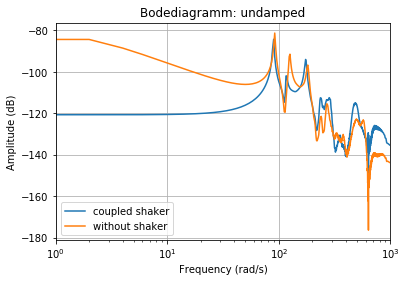

In [66]:
#compare amplitude
plt.plot(f, Ampl2,label= 'coupled shaker')
plt.plot(f, Ampl,label='without shaker')
plt.title('Bodediagramm: undamped')
plt.ylabel('Amplitude (dB)')
plt.xlabel('Frequency (rad/s)')
plt.xscale('log')
plt.xlim(1, 1000)
plt.grid(True)
plt.legend()
plt.show()

#new tf compute
KC2, M

In [124]:
force = np.array(np.zeros((3*N, y_t.shape[0])))
force[Iz[NC],:] = y_t # chirp signal as voltage input

In [ ]:
start_time = time.time()

# Time integration with Newmark-Method
u0 = np.zeros(3*N) # Initial displacement set to 0.
u, v, a = Newmark(M, C, Kc2, force, t, u0)

print("--- %s seconds ---" % (time.time() - start_time))

* Plot the FRF from plate force to center displacement from coupled plate-sahker model and pure plate model. Compute the $\Delta$FRF to compare.

* Plot the transfer function(s) in the Nyquist plane. Use different colors to distinguish the frequency ranges around the resonance peaks.